### 1. Testing the Environment


In [1]:
# Testing the environment

import cv2
import numpy as np
import tensorflow as tf

print("OpenCV version", cv2.__version__)

print("Numpy version", np.__version__)

print("Tensorflow version", tf.__version__)


OpenCV version 3.1.0
Numpy version 1.13.1
Tensorflow version 1.3.0


### 2. Loading Exposure Images into a list

In [6]:
import cv2
import glob
import numpy as np
import os
from matplotlib import image as mpimg
from matplotlib import pyplot as plt

% matplotlib inline

# Loading exposure images into a list
IMG_SRC = os.path.join("..","images","hdr","*.JPG")

img_lst = []

# Note: This works because we have ordered the images in the sequence of exposure time
for image in glob.glob(IMG_SRC):
    im = mpimg.imread(image)
    img_lst.append(im)

exposure_times = np.array([15.0, 2.5, 0.25, 0.0333], dtype=np.float32)


### 3. Merge exposures into HDR Image

We will merge exposure sequences into one HDR using 2 methods:

> 1. Debvec
> 2. Robertson

In [10]:
merge_debvec    = cv2.createMergeDebevec()
hdr_debvec      = merge_debvec.process(img_lst, times=exposure_times.copy())
merge_robertson = cv2.createMergeRobertson()
hdr_robertson   = merge_robertson.process(img_lst, times=exposure_times.copy())

### 4. Tonemap HDR Image

We now map the 32-bit HDR data into a [0...1] range image.

In [11]:
tonemap_1     = cv2.createTonemapDurand(gamma=2.2)
res_debvec    = tonemap_1.process(hdr_debvec.copy())
tonemap_2     = cv2.createTonemapDurand(gamma=1.3)
res_robertson = tonemap_2.process(hdr_robertson.copy())

### 5. Converting to 8-bit and plotting

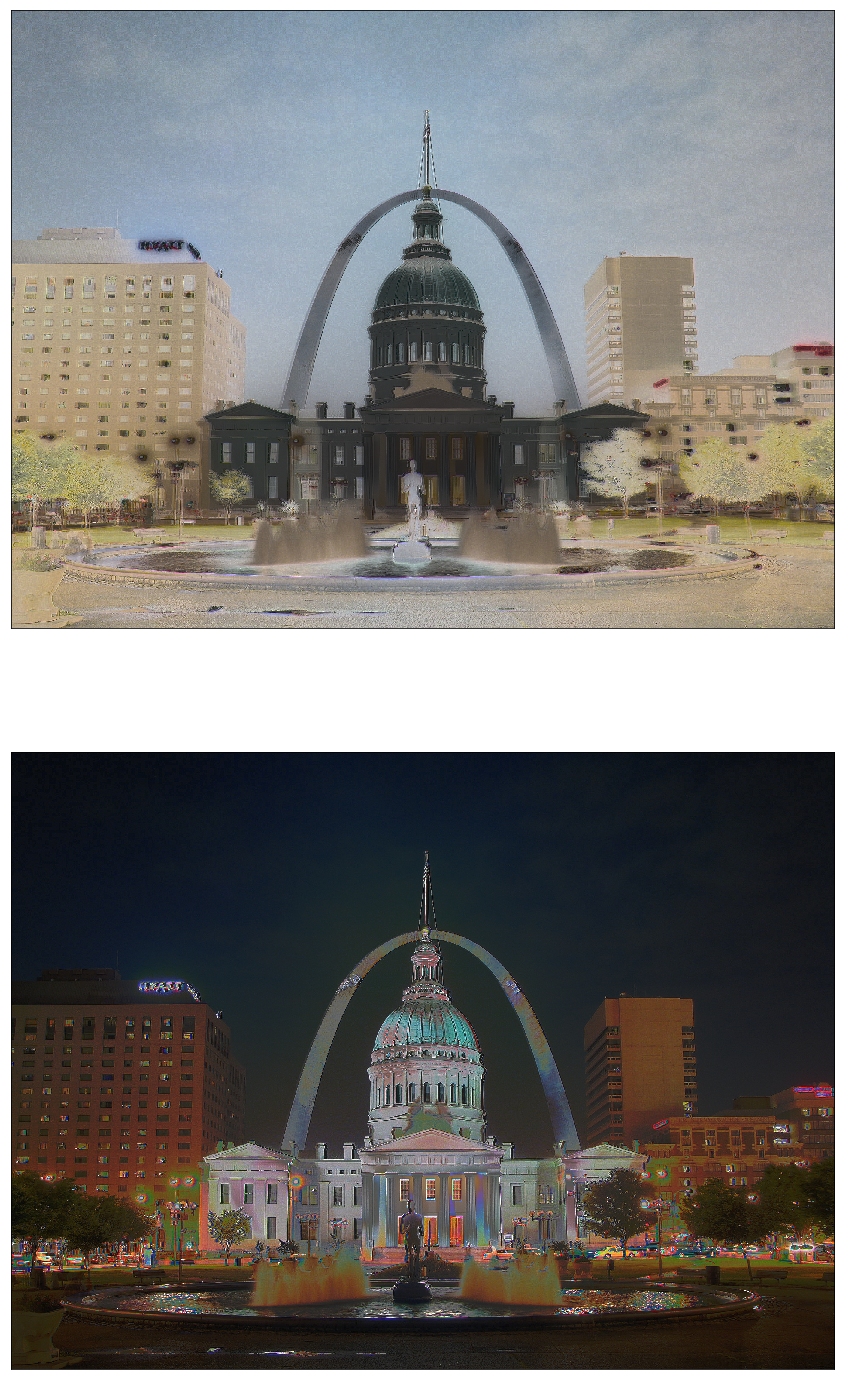

In [23]:
res_debvec_8bit    = np.clip(res_debvec*255, 0, 255).astype('uint8')
res_robertson_8bit = np.clip(res_robertson*255, 0, 255).astype('uint8')

plt.figure("HDR Imaging",figsize=(25,25))
    
# Debvec    
plt.subplot(211)
plt.imshow(res_debvec_8bit)
plt.xticks([]), plt.yticks([])
 
# Robertson
plt.subplot(212)
plt.imshow(res_robertson_8bit)
plt.xticks([]), plt.yticks([])
        
plt.show()

### 6. Merge exposure using Mertens fusion

In [26]:
merge_mertens = cv2.createMergeMertens()
res_mertens = merge_mertens.process(img_lst)

### 7. HDR Imaging based on Merten's fusion

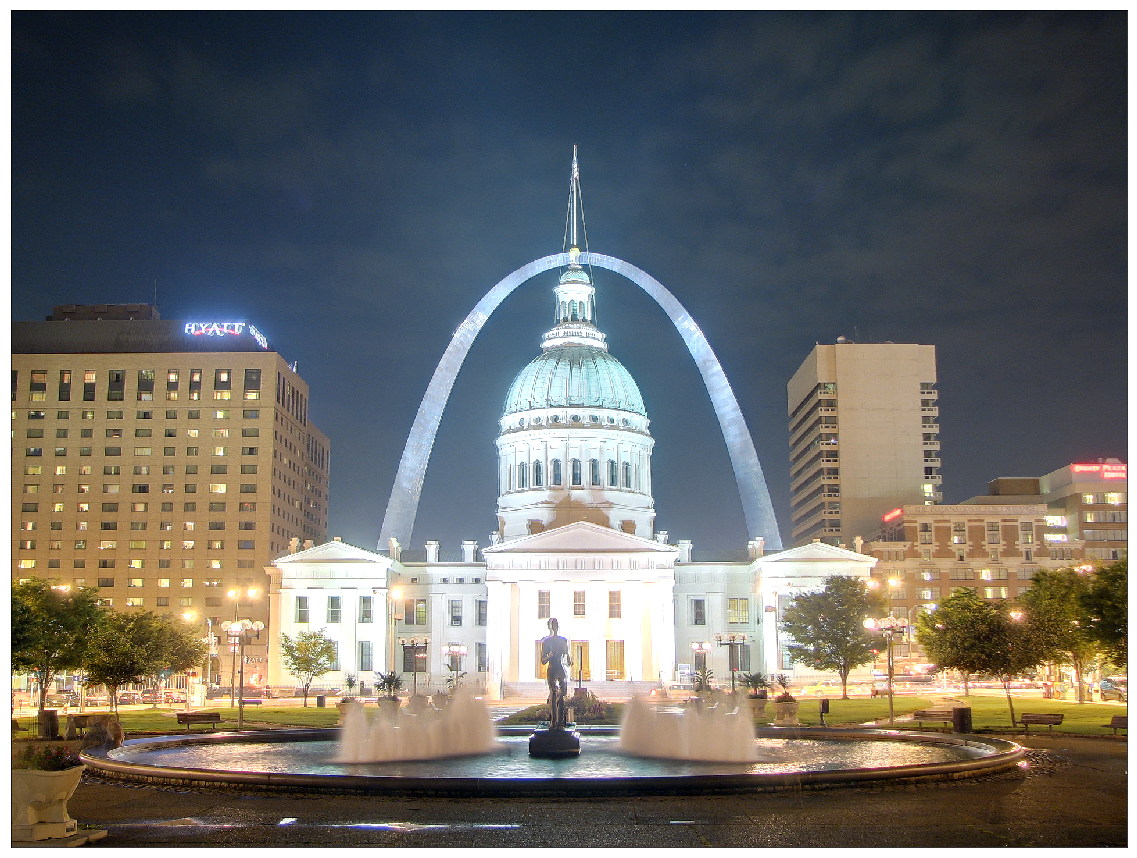

In [28]:
res_mertens_8bit = np.clip(res_mertens*255, 0, 255).astype('uint8')

plt.figure("HDR Imaging",figsize=(20,20))

plt.imshow(res_mertens_8bit)
plt.xticks([]), plt.yticks([])
        
plt.show()

### 8. Estimate Camera Response Function

The Camera Response Function (CRF) gives use the connection between the scene radiance to the measured intensity values. 

We will estimate the inverse camera response function and use it for HDR merge.

In [32]:
cal_debvec = cv2.createCalibrateDebevec()
crf_debvec = cal_debvec.process(img_lst, times=exposure_times)
hdr_debvec = merge_debvec.process(img_lst, times=exposure_times.copy(), response=crf_debvec.copy())

cal_robertson = cv2.createCalibrateRobertson()
crf_robertson = cal_robertson.process(img_lst, times=exposure_times)
hdr_robertson = merge_robertson.process(img_lst, times=exposure_times.copy(), response=crf_robertson.copy())


plt.figure("Camera Response Function",figsize=(20,20))
    
# Debvec    
plt.subplot(211)
plt.imshow(crf_debvec)
plt.xticks([]), plt.yticks([])
 
# Robertson
plt.subplot(212)
plt.imshow(crf_robertson)
plt.xticks([]), plt.yticks([])
        
plt.show()

# How to get the camera response function